# Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network-head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception V3
7. Examples

In [3]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 195 kB/s 
     |████████████████████████████████| 79 kB 9.0 MB/s 
     |████████████████████████████████| 146 kB 55.8 MB/s 
     |████████████████████████████████| 209 kB 72.1 MB/s 
     |████████████████████████████████| 181 kB 70.7 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 64.6 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.1-py3-none-any.whl size=138400 sha256=9045b9327611e7d3321b83fe517668350520d13296b335e26b6fdd6a16930bf7
  Stored in directory: /root/.cache/pip/wheels/57/d8/aa/22cfa23ed29a4f0e3cc742f31de155f05c147b6f6a0e0a23bb
Successfully built databricks-cli
  Attempting uninstall

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import copy
import warnings

warnings.filterwarnings('ignore')

In [2]:
#hyperparameter tuning
import mlflow
import mlflow.pytorch

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Deep CNNs - VGG16, Resnet, Inception, Squeezenet

## Functions

In [33]:
def evaluation(dataloader, model):
  total, correct = 0,0
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    pred = torch.argmax(outputs.data, axis=1)
    total += labels.shape[0]
    correct += (pred==labels).sum().item()
  
  return 100*correct/total

def fit(model, epochs=16, evaluation = evaluation):
  global best_model
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)
  min_loss = 1000

  for epoch in range(1,max_epochs+1):
    i=0
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()

      # saving best model
      if loss.item()<min_loss:
        min_loss = loss.item()
        best_model = copy.deepcopy(model.state_dict())
        print(f'minimum loss : {min_loss}')

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, model):0.2f} test acc : {evaluation(testloader, model):0.2f}')

  plt.plot(losses)
  plt.show()

# Inception
def evaluation_inception(dataloader, model):
  total, correct = 0,0
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, aux_outputs = model(inputs)
    pred = torch.argmax(outputs.data, axis=1)
    total += labels.shape[0]
    correct += (pred==labels).sum().item()
  
  return 100*correct/total

def fit_inception(model, epochs=16, evaluation = evaluation_inception):
  global best_model
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)
  min_loss = 1000

  for epoch in range(1,max_epochs+1):
    i=0
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs, aux_outputs = model(inputs)
      loss = loss_fn(outputs, labels) + 0.3*loss_fn(aux_outputs, labels)
      loss.backward()
      opt.step()

      # saving best model
      if loss.item()<min_loss:
        min_loss = loss.item()
        best_model = copy.deepcopy(model.state_dict())
        print(f'minimum loss : {min_loss}')

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, model):0.2f} test acc : {evaluation(testloader, model):0.2f}')

  plt.plot(losses)
  plt.show()

## Data loading and Visualisation

In [36]:
transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # (mean of R,G,B), (std of R,G,B)
                                      ])
transform_test = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                      ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./', 
                                        train=True,
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./', 
                                        train=False,
                                        download=True, 
                                        transform=transform_test)

12.0%

In [ ]:
num_classes = 10
batch_size = 4

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

In [ ]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5 # img * std + mean (un normalising)
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

def imbatch_show(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

In [ ]:
for i in range(4):
  imbatch_show(trainloader)

## VGG-16

https://pytorch.org/vision/stable/models.html

https://pytorch.org/vision/0.8/_modules/torchvision/models/vgg.html

In [ ]:
vgg = models.vgg16_bn()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(vgg.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
vgg.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
vgg.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
list(vgg.classifier.children())[:-1]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False)]

In [ ]:
# modifying output
final_in_features = vgg.classifier[6].in_features #num of input features for last layer
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
vgg.classifier = nn.Sequential(*mod_classifier)
mod_classifier

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=10, bias=True)]

In [ ]:
# modifying output while making network:
vgg_ = models.vgg16_bn(num_classes=10)
print(vgg_.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


## Train VGG with CIFAR10

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluation(dataloader, model):
  total, correct = 0,0
  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    pred = torch.argmax(outputs.data, axis=1)
    total += labels.shape[0]
    correct += (pred==labels).sum().item()
  
  return 100*correct/total

In [ ]:
#training arc
def fit(model, epochs=16):
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)

  for epoch in range(1,max_epochs+1):
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, vgg):0.2f} test acc : {evaluation(testloader, vgg):0.2f}')

  plt.plot(losses)
  plt.show()

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.025)

In [ ]:
# for i,data in enumerate(trainloader,0):
#       pass
# print(i)

iteration 100/3125.0,epoch 1/4, loss: 1.4605597257614136
iteration 200/3125.0,epoch 1/4, loss: 2.179793119430542
iteration 300/3125.0,epoch 1/4, loss: 1.6601759195327759
iteration 400/3125.0,epoch 1/4, loss: 1.7249811887741089
iteration 500/3125.0,epoch 1/4, loss: 1.8011713027954102
iteration 600/3125.0,epoch 1/4, loss: 1.55449640750885
iteration 700/3125.0,epoch 1/4, loss: 1.4668618440628052
iteration 800/3125.0,epoch 1/4, loss: 1.6122106313705444
iteration 900/3125.0,epoch 1/4, loss: 1.6750315427780151
iteration 1000/3125.0,epoch 1/4, loss: 1.532333493232727
iteration 1100/3125.0,epoch 1/4, loss: 1.551572561264038
iteration 1200/3125.0,epoch 1/4, loss: 1.4809011220932007
iteration 1300/3125.0,epoch 1/4, loss: 1.6369318962097168
iteration 1400/3125.0,epoch 1/4, loss: 1.5099191665649414
iteration 1500/3125.0,epoch 1/4, loss: 1.3796093463897705
iteration 1600/3125.0,epoch 1/4, loss: 1.7259634733200073
iteration 1700/3125.0,epoch 1/4, loss: 2.0268006324768066
iteration 1800/3125.0,epoch 

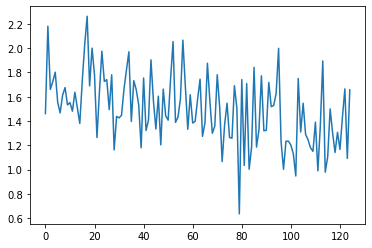

In [ ]:
fit(vgg, epochs=4)

Training all parameters like this take time and is less efficient.

Hence we will only train final layers of the pretrained model

## Freeze Layers for Convolutional Operations

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# freeze all layers
for param in vgg.parameters():
  param.requires_grad=False

In [ ]:
# unfreeze last layer
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
  if param.requires_grad is True:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.025)

iteration 100/3125.0,epoch 1/4, loss: 1.7797527313232422
iteration 200/3125.0,epoch 1/4, loss: 1.4230928421020508
iteration 300/3125.0,epoch 1/4, loss: 2.1778624057769775
iteration 400/3125.0,epoch 1/4, loss: 2.406358242034912
iteration 500/3125.0,epoch 1/4, loss: 1.0221807956695557
iteration 600/3125.0,epoch 1/4, loss: 1.5265069007873535
iteration 700/3125.0,epoch 1/4, loss: 2.115964651107788
iteration 800/3125.0,epoch 1/4, loss: 1.680800437927246
iteration 900/3125.0,epoch 1/4, loss: 1.5049285888671875
iteration 1000/3125.0,epoch 1/4, loss: 1.6729388236999512
iteration 1100/3125.0,epoch 1/4, loss: 1.4917718172073364
iteration 1200/3125.0,epoch 1/4, loss: 1.0666556358337402
iteration 1300/3125.0,epoch 1/4, loss: 1.8215625286102295
iteration 1400/3125.0,epoch 1/4, loss: 1.8102788925170898
iteration 1500/3125.0,epoch 1/4, loss: 1.1007362604141235
iteration 1600/3125.0,epoch 1/4, loss: 2.5264554023742676
iteration 1700/3125.0,epoch 1/4, loss: 2.034893274307251
iteration 1800/3125.0,epoch

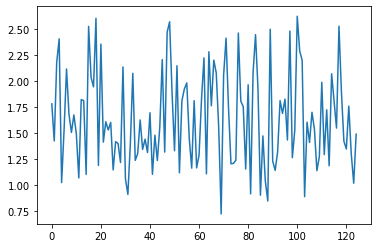

In [ ]:
fit(vgg, epochs=4)

## Checkpointing

In [34]:
def fit(model, epochs=16, evaluation = evaluation):
  global best_model
  max_epochs = epochs
  losses = []
  i=0
  i_max = np.ceil(50000/batch_size)
  min_loss = 1000

  for epoch in range(1,max_epochs+1):
    i=0
    for inputs, labels in trainloader:
      i+=1
      inputs, labels = inputs.to(device), labels.to(device)

      opt.zero_grad()    
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      loss.backward()
      opt.step()

      # saving best model
      if loss.item()<min_loss:
        min_loss = loss.item()
        best_model = copy.deepcopy(model.state_dict())
        print(f'minimum loss : {min_loss}')

      del inputs, labels, outputs
      torch.cuda.empty_cache()

      if i%100 == 0:
        losses.append(loss.item())
        print(f'iteration {i}/{i_max},epoch {epoch}/{max_epochs}, loss: {loss.item()}')
    
    # losses.append(loss.item())
    print(f'Epoch {epoch}/{max_epochs}, train acc : {evaluation(trainloader, model):0.2f} test acc : {evaluation(testloader, model):0.2f}')

  plt.plot(losses)
  plt.show()

In [ ]:

vgg = models.vgg16_bn()
vgg = vgg.to(device)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.025)
fit(vgg, epochs=4)

In [ ]:
vgg.load_state_dict(best_model)
print(f'train acc : {evaluation(trainloader, vgg):0.2f} test acc : {evaluation(testloader, vgg):0.2f}')

## ResNet - has identity maping

https://pytorch.org/vision/0.8/_modules/torchvision/models/resnet.html

In [ ]:
resnet = models.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

minimum loss : 2.216601610183716
minimum loss : 2.191028356552124
minimum loss : 2.112586498260498
minimum loss : 2.0414929389953613
minimum loss : 2.041011333465576
minimum loss : 1.8804432153701782
minimum loss : 1.8539769649505615
minimum loss : 1.748898983001709
minimum loss : 1.6484529972076416
iteration 100/50000.0,epoch 1/4, loss: 1.821717381477356
minimum loss : 1.5503023862838745
minimum loss : 1.4982610940933228
minimum loss : 1.3708652257919312
minimum loss : 1.3562980890274048
minimum loss : 1.2309075593948364
iteration 200/50000.0,epoch 1/4, loss: 1.829284429550171
minimum loss : 1.0569095611572266
minimum loss : 0.9999018907546997
iteration 300/50000.0,epoch 1/4, loss: 1.6302722692489624
minimum loss : 0.805530309677124
iteration 400/50000.0,epoch 1/4, loss: 1.6464474201202393
iteration 500/50000.0,epoch 1/4, loss: 1.6738855838775635
iteration 600/50000.0,epoch 1/4, loss: 1.3429938554763794
iteration 700/50000.0,epoch 1/4, loss: 1.9573283195495605
iteration 800/50000.0,ep

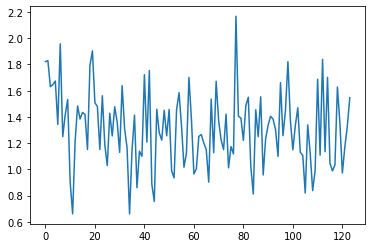

In [ ]:
fit(resnet, epochs=4)

In [ ]:
resnet.load_state_dict(best_model)
print(f'train acc : {evaluation(trainloader, resnet):0.2f} test acc : {evaluation(testloader, resnet):0.2f}')

train acc : 58.27 test acc : 57.63


## Inception - has two outputs

https://pytorch.org/vision/main/_modules/torchvision/models/inception.html

In [ ]:
inception = models.inception_v3(pretrained=True)
print(inception)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
for param in inception.parameters():
  param.requires_grad = False

aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

for param in inception.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:
dir(transforms)

In [ ]:
# We need to resize images for inception
transform_train = transforms.Compose([transforms.RandomResizedCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])
transform_train = transforms.Compose([transforms.RandomResizedCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', download=True,
                                        train=True,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', download=True,
                                        train=False,
                                        transform=transform_train)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_size=16
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

minimum loss : 3.1450860500335693
minimum loss : 2.9560959339141846
minimum loss : 2.9346463680267334
minimum loss : 2.9001190662384033
minimum loss : 2.822277784347534
minimum loss : 2.792027711868286
minimum loss : 2.7325854301452637
minimum loss : 2.7115278244018555
minimum loss : 2.68673038482666
minimum loss : 2.623561382293701
iteration 100/3125.0,epoch 1/4, loss: 2.7870287895202637
minimum loss : 2.5751729011535645
minimum loss : 2.569486379623413
minimum loss : 2.526020050048828
minimum loss : 2.439802408218384
minimum loss : 2.3103907108306885
minimum loss : 2.307683229446411
minimum loss : 2.2410433292388916
minimum loss : 2.1517210006713867
iteration 200/3125.0,epoch 1/4, loss: 2.3165032863616943
minimum loss : 2.117558002471924
minimum loss : 2.0397448539733887
minimum loss : 1.995521903038025
minimum loss : 1.8534877300262451
iteration 300/3125.0,epoch 1/4, loss: 2.3850111961364746
minimum loss : 1.8236197233200073
iteration 400/3125.0,epoch 1/4, loss: 2.295398235321045
mi

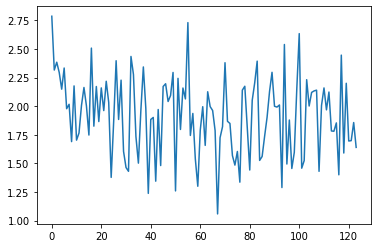

In [ ]:
fit_inception(inception, epochs=4)

In [ ]:
inception.load_state_dict(best_model)
print(f'train acc : {evaluation_inception(trainloader, inception):0.2f} test acc : {evaluation_inception(testloader, inception):0.2f}')

train acc : 48.68 test acc : 48.39


## SqueezeNet - Smaller and Faster than VGG or AlexNet

In [ ]:
squeezenet = models.squeezenet1_0(pretrained=True)
print(squeezenet)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
squeezenet.classifier[3]

AdaptiveAvgPool2d(output_size=(1, 1))

In [ ]:
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

In [ ]:
# mod_classifier = list(squeezenet.classifier.children())
# mod_classifier.append(nn.Linear(4000, num_classes))
# squeezenet.classifier = nn.Sequential(*mod_classifier)

In [ ]:
input, label = next(iter(trainloader))
squeezenet(input).shape

torch.Size([16, 10])

In [ ]:
for param in squeezenet.parameters():
  param.requires_grad = False

squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

for param in squeezenet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 512, 1, 1])
torch.Size([10])


In [ ]:
squeezenet = squeezenet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

minimum loss : 2.439856767654419
minimum loss : 2.3967392444610596
minimum loss : 2.2949059009552
minimum loss : 2.2645206451416016
minimum loss : 2.250654935836792
minimum loss : 2.2349178791046143
minimum loss : 2.1685168743133545
minimum loss : 2.158726930618286
minimum loss : 2.121410846710205
iteration 100/3125.0,epoch 1/4, loss: 2.446866035461426
minimum loss : 2.1022872924804688
iteration 200/3125.0,epoch 1/4, loss: 2.332298517227173
minimum loss : 1.9875812530517578
iteration 300/3125.0,epoch 1/4, loss: 2.4998598098754883
iteration 400/3125.0,epoch 1/4, loss: 2.4684810638427734
iteration 500/3125.0,epoch 1/4, loss: 2.6138858795166016
iteration 600/3125.0,epoch 1/4, loss: 2.315152168273926
iteration 700/3125.0,epoch 1/4, loss: 2.31679630279541
iteration 800/3125.0,epoch 1/4, loss: 2.331728935241699
iteration 900/3125.0,epoch 1/4, loss: 2.4712953567504883
iteration 1000/3125.0,epoch 1/4, loss: 2.5125279426574707
iteration 1100/3125.0,epoch 1/4, loss: 2.6175472736358643
iteration 

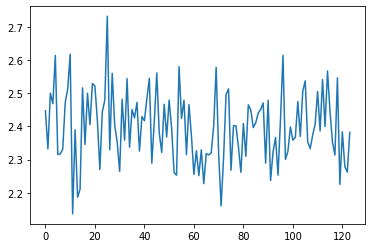

In [ ]:
fit(squeezenet, epochs=4)

In [ ]:
squeezenet.load_state_dict(best_model)
print(f'train acc : {evaluation(trainloader, squeezenet):0.2f} test acc : {evaluation(testloader, squeezenet):0.2f}')

train acc : 10.15 test acc : 10.08


# Visualising CNNs

## Loading Data

In [13]:
# !unzip data.zip

In [14]:
# print(classes)

In [15]:
# with open('data/imagenet_labels.txt') as f:
#   classes = eval(f.read())
# print(classes)

In [16]:
transform = transforms.Compose([transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize((0.845,0.456,0.406), (0.229,0.224,0.225))
                               ])

In [17]:
num_classes = 10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
# evalset = torchvision.datasets.ImageFolder(root='./data/imagenet', transform=transform)
evalset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [19]:
batch_size = 1
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)

In [20]:
images, labels = next(iter(evalloader))
print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
8


## Loading model

In [24]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [25]:
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

In [26]:
# setting in eval mode
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Visualise Image

In [27]:
def imshow(img, title):

  std_correction =  np.asarray([0.229, 0.224, 0.225]).reshape(3,1,1)
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3,1,1)
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction # un normalising

  plt.figure(figsize=(batch_size*4,4))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

def imbatch_show(dataloader, model):
  images, labels = next(iter(dataloader))
  print(classes[labels])
  outputs = model(images)
  pred = torch.argmax(outputs.data, axis=1)
  
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

  return images, pred

bird


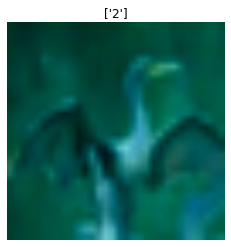

truck
torch.Size([1, 3, 224, 224])


In [28]:
images, pred = imbatch_show(evalloader, model)
print(classes[pred])
print(images.shape)

## Occlusion Analysis

In [29]:
outputs = model(images)
print(outputs.shape)
outputs = nn.functional.softmax(outputs, dim=1)
prob_no_occ, pred = torch.max(outputs.data, axis=1)
prob_no_occ = prob_no_occ[0].item()
print('prob without occlusion : ', prob_no_occ)

torch.Size([1, 10])
prob without occlusion :  0.15744221210479736


In [30]:
def occlusion(model, image, label, occ_size=50, occ_stride=50, occ_pixel=0.5):
  width, height = image.shape[-2], image.shape[-1]

  output_height = int(np.ceil((height-occ_size)/occ_stride))
  output_width  = int(np.ceil((width-occ_size)/occ_stride))

  heatmap = torch.zeros(output_height, output_width)

  for h in range(0,height):
    for w in range(0,width):

      h_start = h*occ_stride
      w_start = w*occ_stride
      h_end = min(height, h_start + occ_size)
      w_end = min(width, w_start + occ_size)

      if w_end >= width or h_end >= height:
        continue
      
      input_image = image.clone().detach()
      input_image[:,:, w_start:w_end, h_start:h_end] = occ_pixel

      output = model(input_image)
      output = nn.functional.softmax(output, dim=1)
      # print(output.shape)
      prob = list(output)[0][label]

      heatmap[h,w] = prob
  return heatmap.detach().numpy()

In [31]:
print(images.shape)

torch.Size([1, 3, 224, 224])


In [32]:
heatmap = occlusion(model, images, pred[0].item(), 28,28)

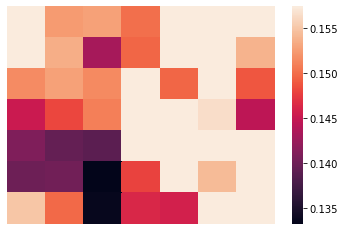

In [33]:
imgplot = sns.heatmap(heatmap, vmax=prob_no_occ, xticklabels=False, yticklabels=False)

## Filter Visualisation

In [8]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
def plot_weights(model, layer_num, single_channel=True, collated=False):
  layer = model.features[layer_num]
  if isinstance(layer, nn.Conv2d):
    weight_tensor = model.features[layer_num].weight.data
    print(weight_tensor.shape)
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
    else:
      print(weight_tensor.shape)
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        'Can only plot weights with three channels if single_channel = False'
  else:
      print('Can only visualise layers which are convolutional')

In [10]:
def plot_filters_multi_channel(weight_tensor):
  num_kernels = weight_tensor.shape[0]

  num_cols=12
  num_rows = num_kernels

  fig = plt.figure(figsize=(num_cols, num_rows))
  for i in range(weight_tensor.shape[0]):
    ax1 = fig.add_subplot(num_rows, num_cols, i+1)
    npimg = np.array(weight_tensor.numpy(), np.float32)
    npimg = (npimg-np.mean(npimg))/np.std(npimg)
    npimg = np.minimum(1,np.maximum(0,npimg+0.5))
    npimg = npimg.transpose((1,2,0))
    ax1.imshow(npimg)
    ax1.axis('off')
    ax1.set_title(str(i))
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
  
  plt.tight_layout()
  plt.show()

In [11]:
def plot_filters_single_channel_big(weight_tensor):

  n_rows = weight_tensor.shape[0]*weight_tensor.shape[2]
  n_cols = weight_tensor.shape[1]*weight_tensor.shape[3]

  npimg = np.array(weight_tensor.numpy(), np.float32)
  npimg = npimg.transpose((0,2,1,3))
  npimg = npimg.ravel().reshape(n_rows, n_cols)
  npimg = npimg.T

  fig, ax = plt.subplots(fifsize=(n_cols/10, n_rows/200))
  imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='Greys', ax=ax, cbar=False)

In [12]:
def plot_filters_single_channel(weight_tensor):

  num_plots = weight_tensor.shape[0]*weight_tensor.shape[1]
  num_cols=12
  num_rows = 1+ num_plots//num_cols

  npimg = np.array(weight_tensor.numpy(), np.float32)
  count=0

  fig = plt.figure(figsize=(num_cols, num_rows))
  for i in range(weight_tensor.shape[0]):
    for j in range(weight_tensor.shape[1]):
      count += 1
      ax1 = fig.add_subplot(num_rows, num_cols, count)
      npimg = np.array(weight_tensor[i,j].numpy(), np.float32)
      npimg = (npimg-np.mean(npimg))/np.std(npimg)
      npimg = np.minimum(1,np.maximum(0,npimg+0.5))
      ax1.imshow(npimg)
      ax1.axis('off')
      ax1.set_title(f'{i},{j}')
      ax1.set_xticklabels([])
      ax1.set_yticklabels([])
  
  plt.tight_layout()
  plt.show()

torch.Size([64, 3, 11, 11])


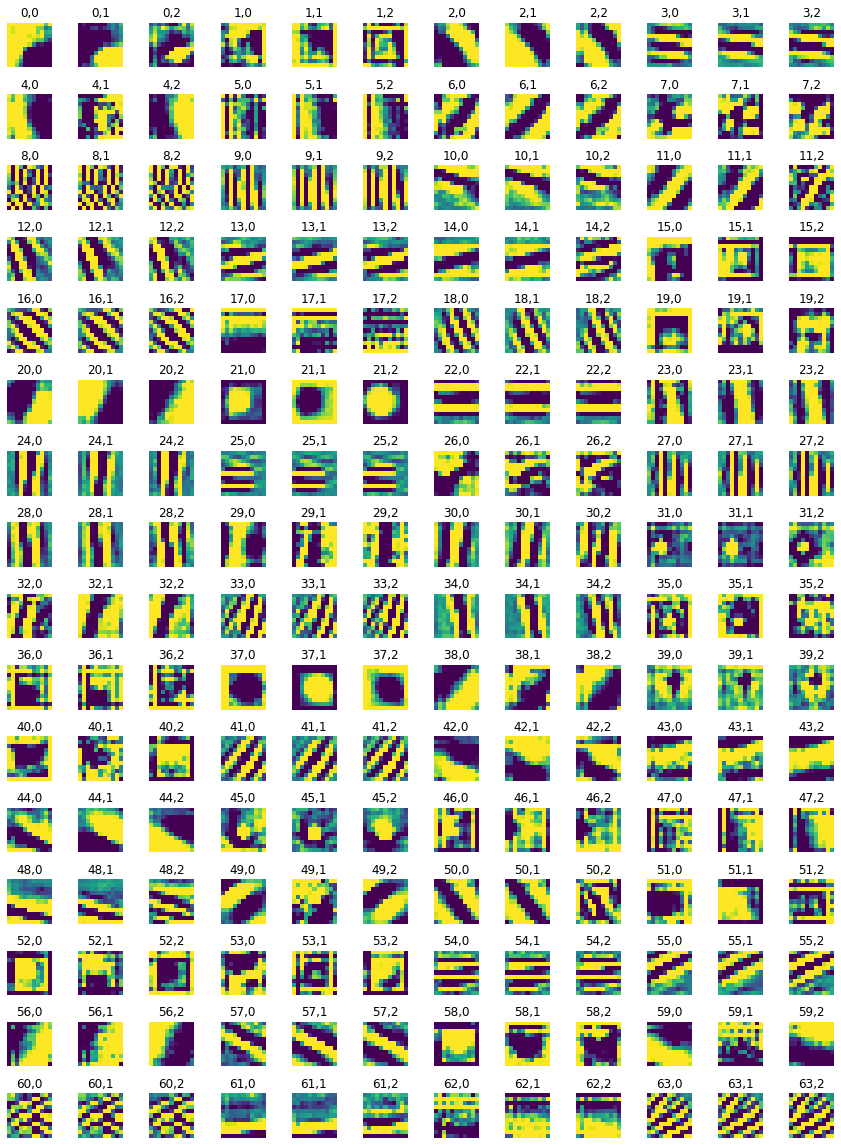

In [19]:
plot_weights(alexnet, 0, single_channel=True)

# Batch Normalisation and Dropout

## Data Loading

In [20]:
transform_train = transforms.Compose([transforms.ToTensor()])

In [21]:
trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform_train)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [22]:
batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [23]:
images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)
print(labels)

torch.Size([4, 1, 28, 28])
torch.Size([4])
tensor([2, 4, 2, 8])


In [24]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5 # img * std + mean (un normalising)
  plt.figure(figsize=(batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

def imbatch_show(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

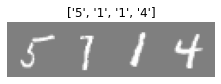

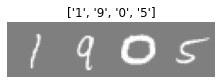

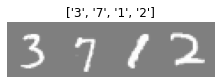

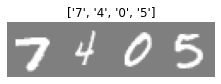

In [25]:
for i in range(4):
  imbatch_show(trainloader)

## Batch norm

In [26]:
class MyNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(nn.Linear(784,48), # 784 = 28*28
                                    nn.ReLU(),
                                    nn.Linear(48,24),
                                    nn.ReLU(),
                                    nn.Linear(24,10))
  
  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.classifier(x)
    return x

In [27]:
class MyNetBN(nn.Module):
  def __init__(self):
    super().__init__()
    self.classifier = nn.Sequential(nn.Linear(784,48),
                                    nn.BatchNorm1d(48),
                                    nn.ReLU(),
                                    nn.Linear(48,24),
                                    nn.BatchNorm1d(24),
                                    nn.ReLU(),
                                    nn.Linear(24,10))
  
  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.classifier(x)
    return x

In [28]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [29]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [30]:
batch_size = 512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [31]:
loss_fn = nn.CrossEntropyLoss()
opt    =  optim.SGD(model_bn.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

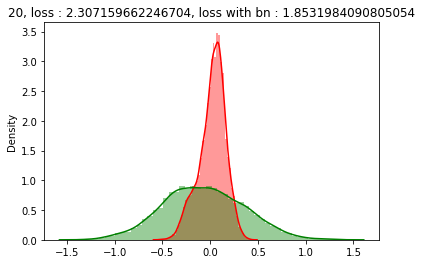

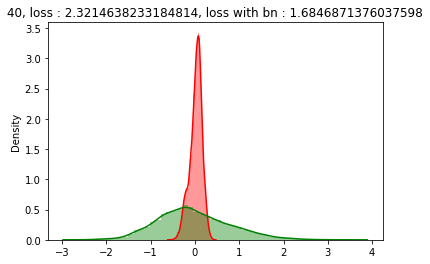

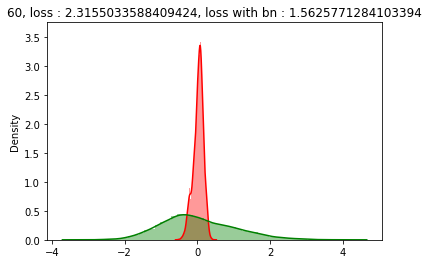

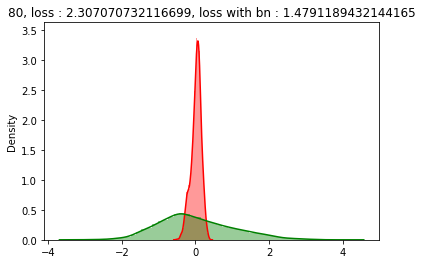

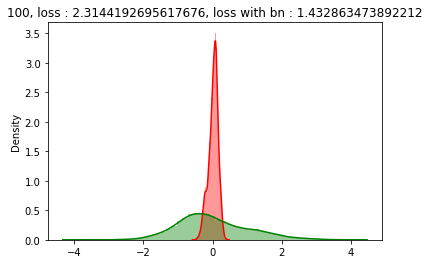

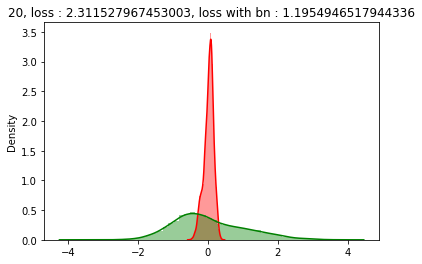

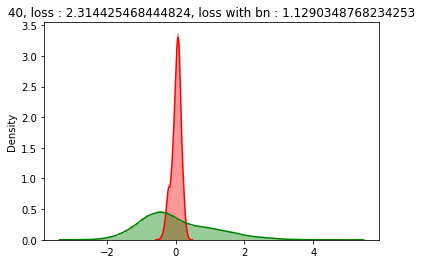

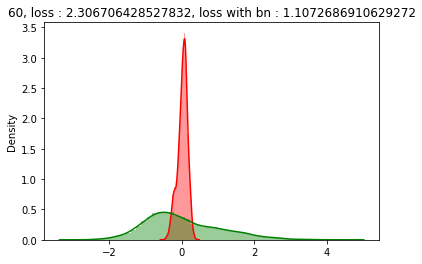

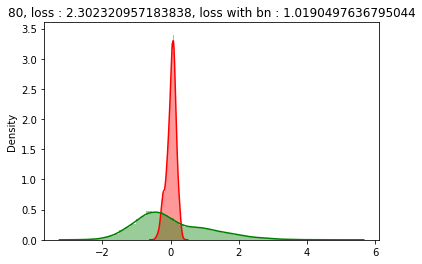

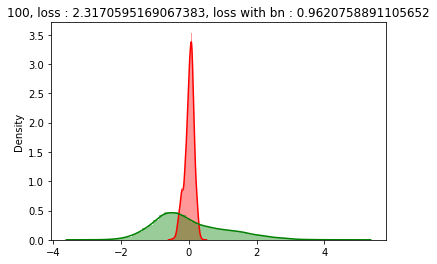

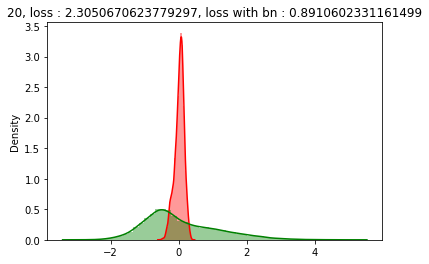

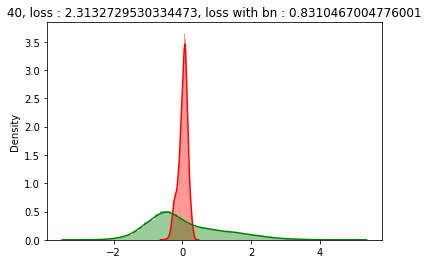

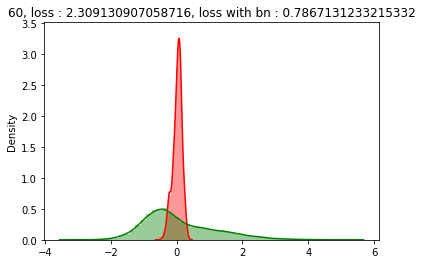

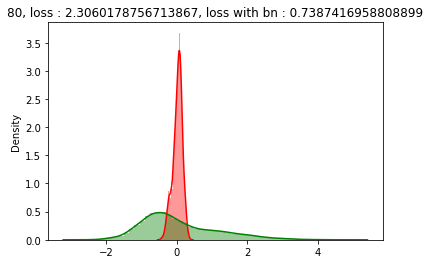

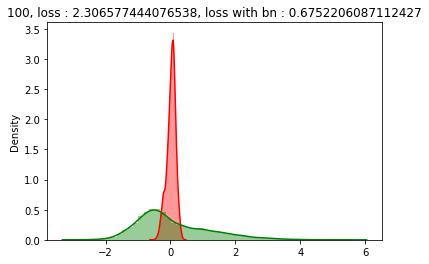

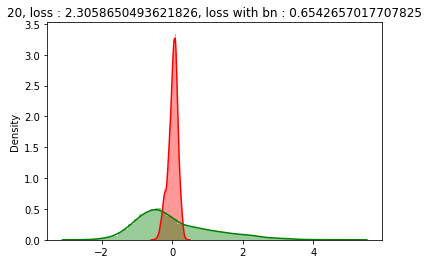

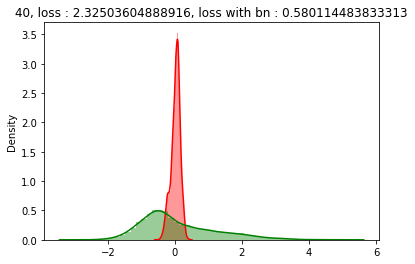

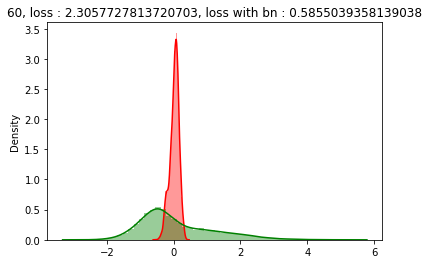

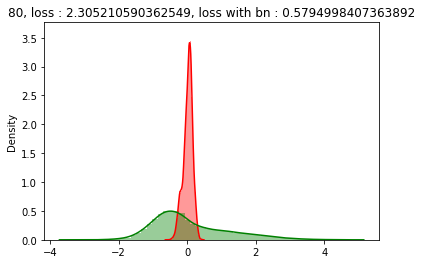

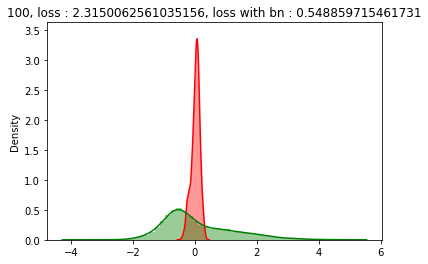

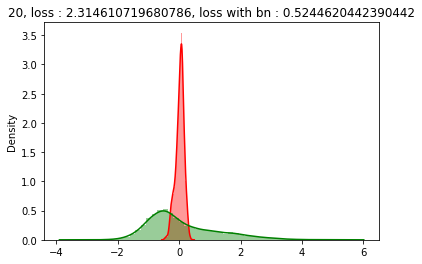

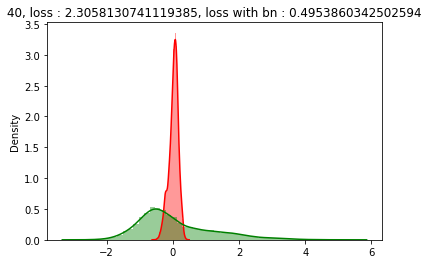

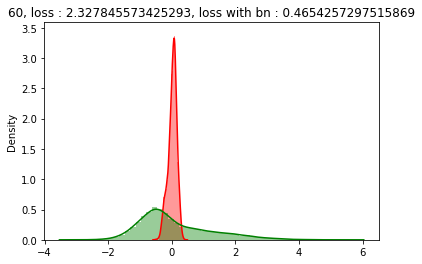

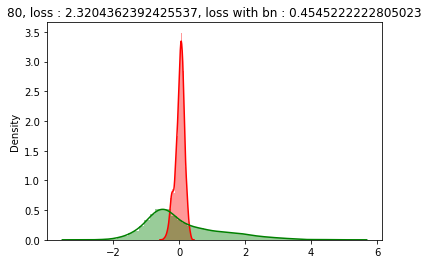

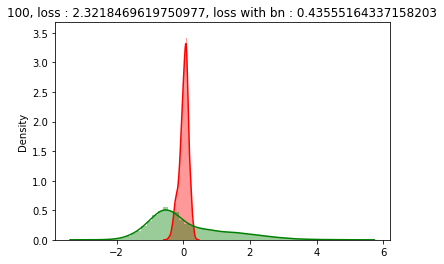

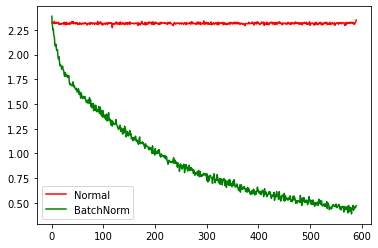

In [32]:
max_epochs = 5
losses = []
losses_bn=[]
i=0

for epoch in range(1,max_epochs+1):
  i=0
  for inputs, labels in trainloader:
    i+=1

    #training normal model
    opt.zero_grad()    
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    #training batch normalised moe
    opt_bn.zero_grad()    
    outputs = model_bn(inputs)
    loss_bn = loss_fn(outputs, labels)
    loss_bn.backward()
    opt_bn.step()

    losses.append(loss.item())
    losses_bn.append(loss_bn.item())

    if i%20 == 0:
      inputs = inputs.view(inputs.shape[0],-1)

      model.eval()
      model_bn.eval()

      a = model.classifier[0](inputs)
      a = model.classifier[1](a)
      a = model.classifier[2](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde=True, color='r', label='Normal')

      b = model_bn.classifier[0](inputs)
      b = model_bn.classifier[1](b)
      b = model_bn.classifier[2](b)
      b = model_bn.classifier[3](b)
      b = model_bn.classifier[4](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde=True, color='g', label='BatchNorm')

      plt.title(f'{i}, loss : {loss.item()}, loss with bn : {loss_bn.item()}')
      plt.show()
      plt.pause(0.5)

      model.train()
      model_bn.train()

plt.plot(losses,'r', label='Normal')
plt.plot(losses_bn, 'g', label='BatchNorm')
plt.legend()
plt.show()

class My

In [33]:
class CNN_BN(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(nn.Conv2d(1,3,5),          # (N, 1, 28, 28) -> (N, 3, 24, 24)
                                  nn.ReLU(),
                                  nn.AvgPool2d(2, stride=2), # (N, 3, 24, 24) -> (N, 3, 12, 12)
                                  nn.Conv2d(3,6,3),          # (N, 3, 12, 12) -> (N, 6, 10, 10)
                                  nn.BatchNorm2d(6)
                                  )
    self.features1 = nn.Sequential(nn.ReLU(),
                                   nn.AvgPool2d(2, stride=2) # (N, 6, 10, 10) -> (N, 6, 5, 5)
                                  )
    self.classifier = nn.Sequential(nn.Linear(150,25),       # (N, 150) -> (N, 25)
                                    nn.ReLU(),
                                    nn.Linear(25,10)         # (N, 25) -> (N, 10)
                                    )
  
  def forward(self,x):
    x = self.features(x)
    x = self.features1(x)
    x = x.view(x.shape[0],-1)
    x = self.classifier(x)
    return x

## Dropout

In [34]:
N = 25
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1,1,N), dim=1)
Y_train = X_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

X_test = torch.unsqueeze(torch.linspace(-1,1,N), dim=1)
Y_test = X_test + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

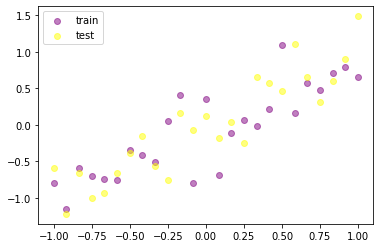

In [35]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [36]:
N_h = 100

#simple network
model = nn.Sequential(nn.Linear(1,N_h),
                      nn.ReLU(),
                      nn.Linear(N_h, N_h),
                      nn.ReLU(),
                      nn.Linear(N_h, 1)
                      )

#network with dropout
model_dropout = nn.Sequential(nn.Linear(1,N_h),
                              nn.Dropout(0.5),
                              nn.ReLU(),
                              nn.Linear(N_h, N_h),
                              nn.Dropout(0.5),
                              nn.ReLU(),
                              nn.Linear(N_h, 1)
                              )

In [37]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.01)
opt_dropout = optim.Adam(model_dropout.parameters(), lr=0.01)

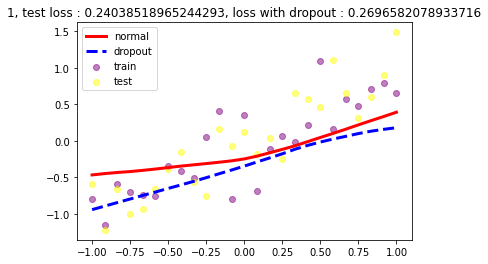

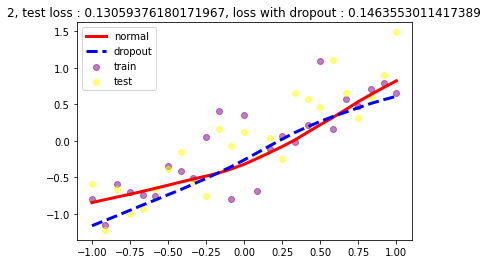

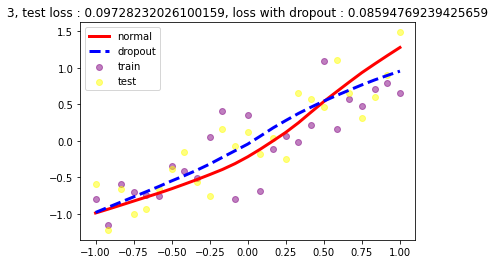

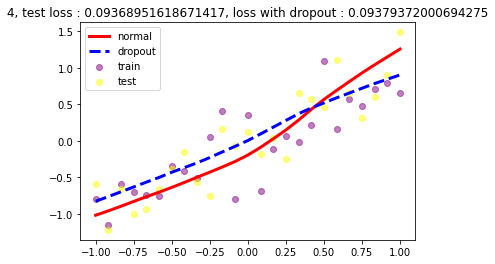

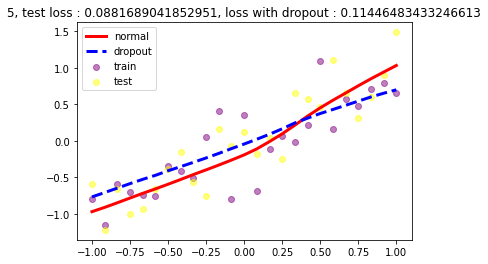

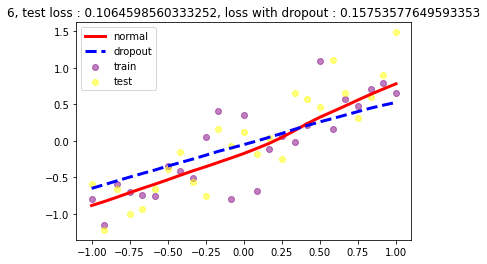

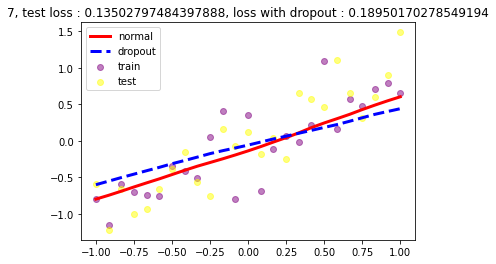

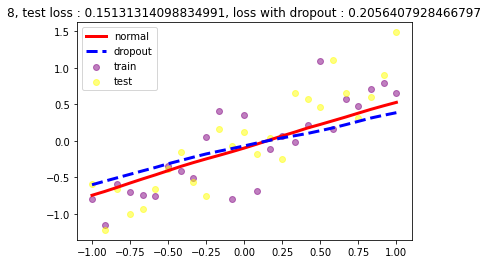

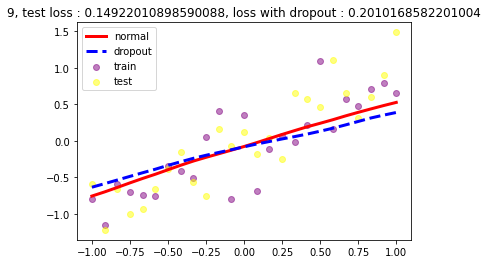

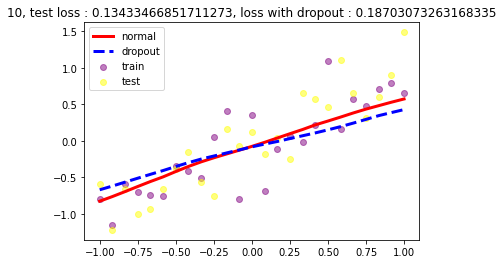

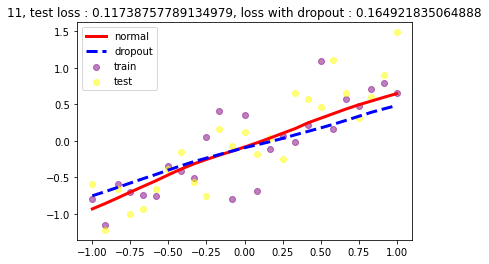

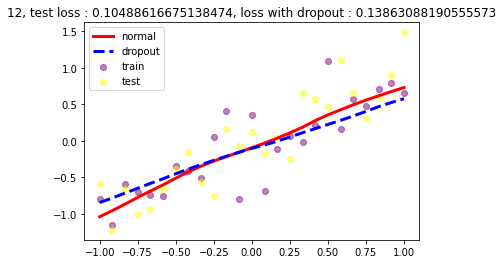

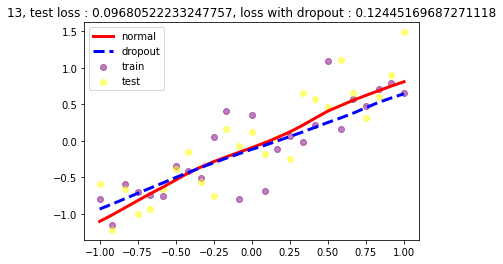

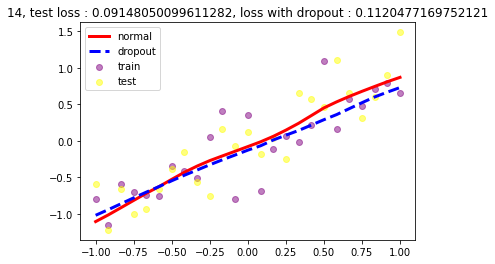

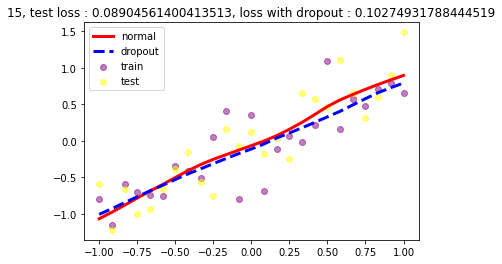

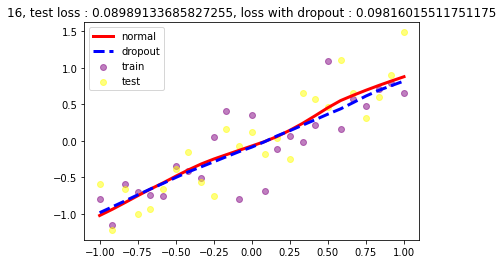

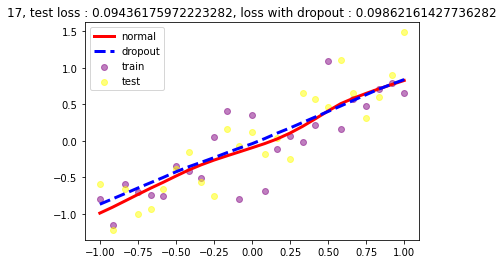

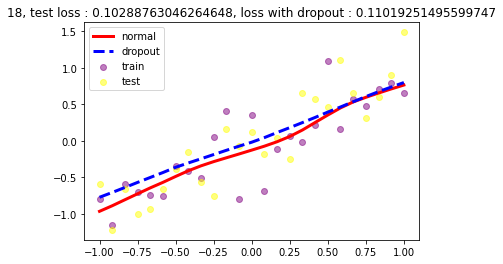

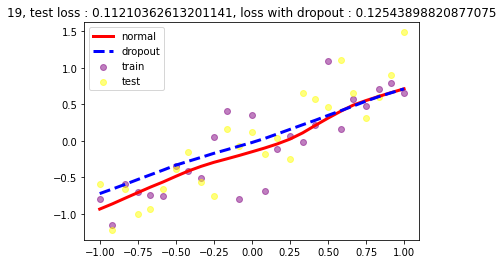

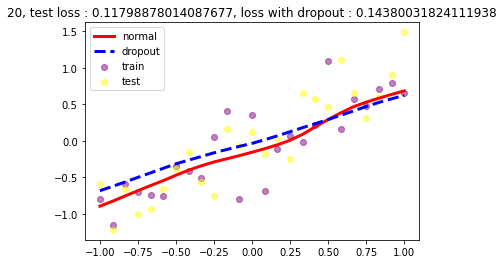

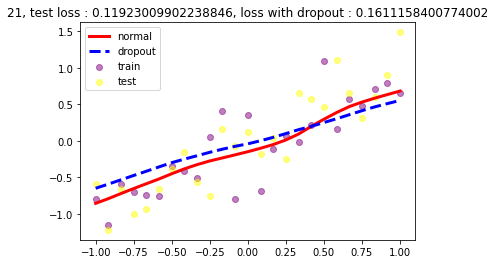

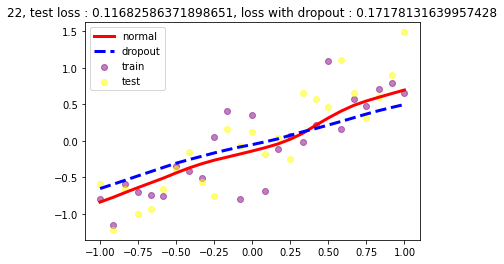

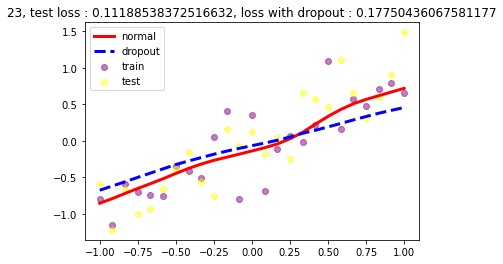

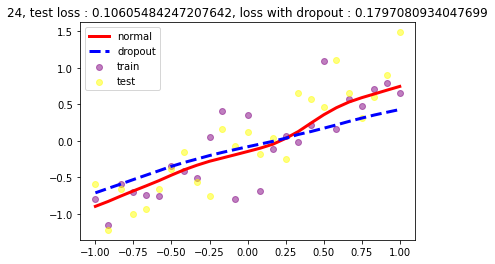

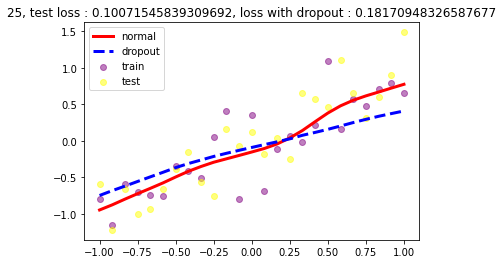

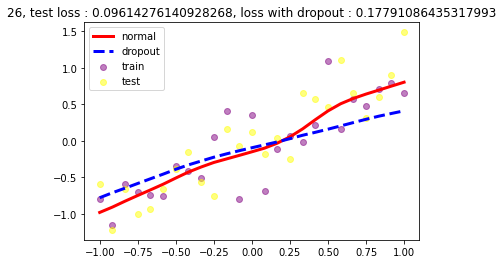

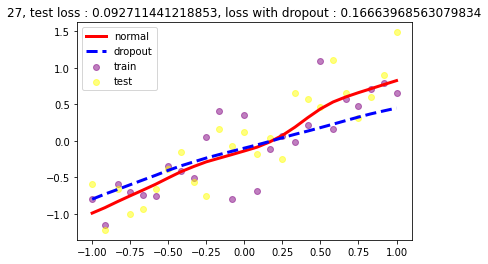

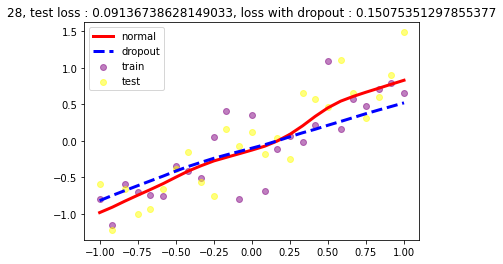

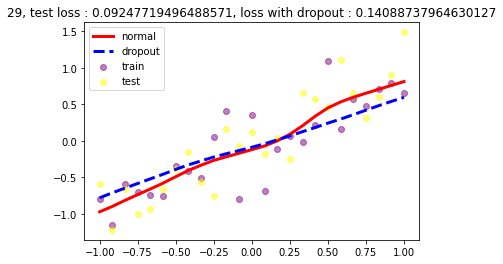

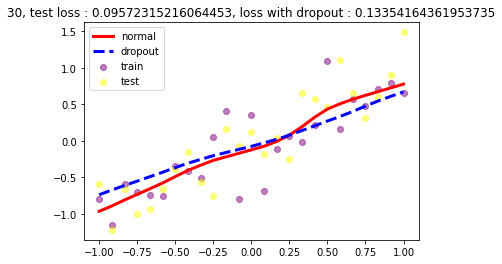

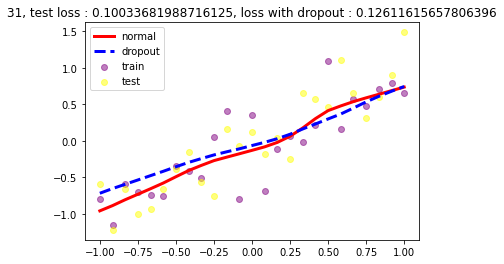

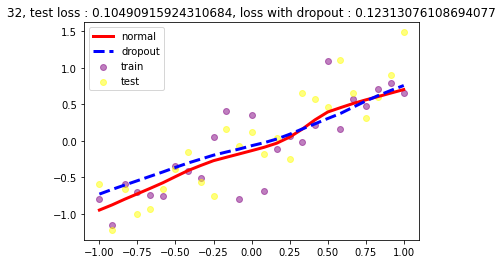

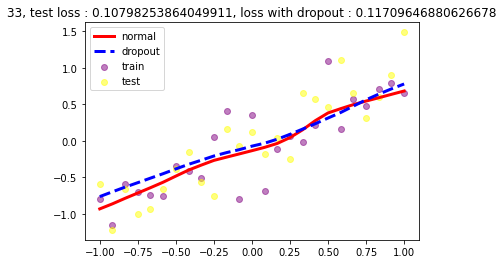

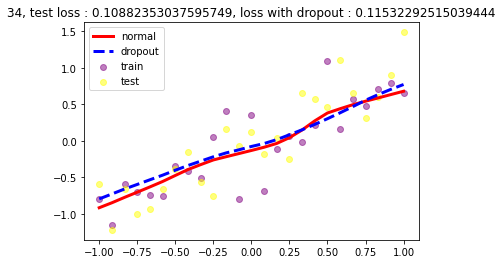

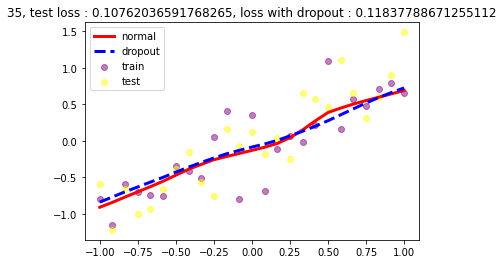

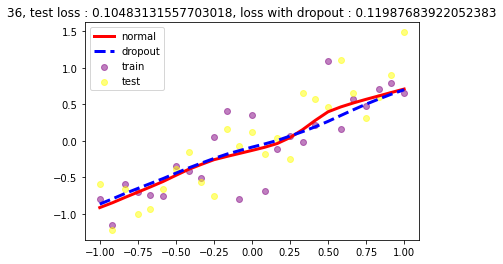

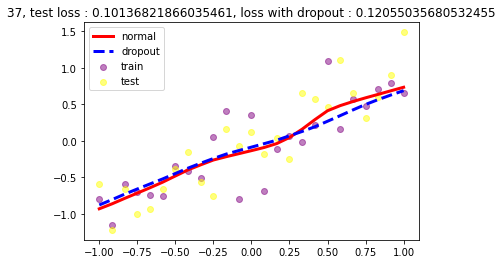

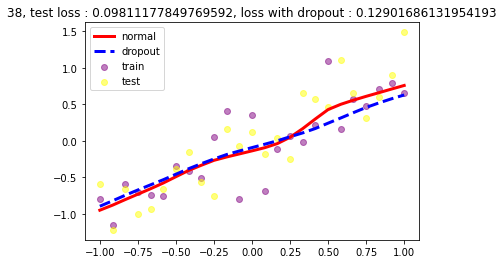

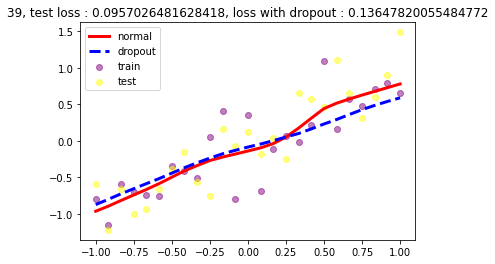

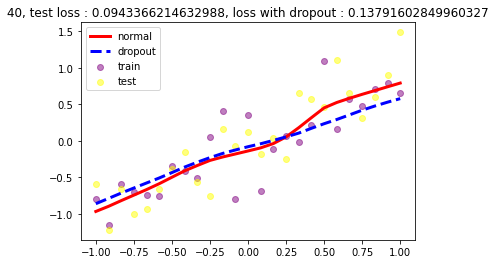

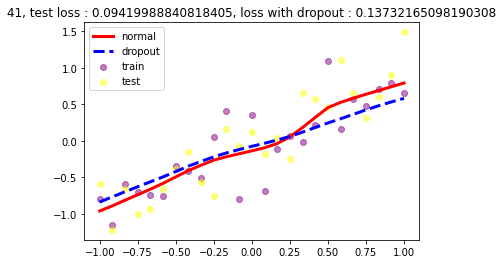

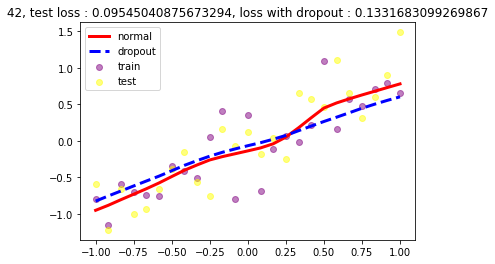

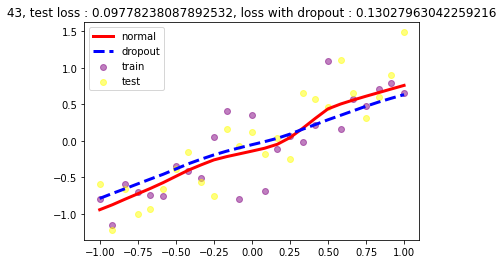

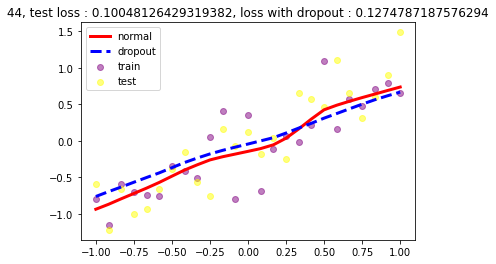

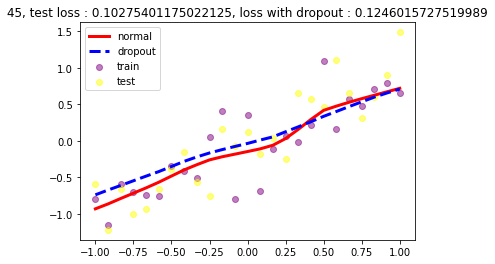

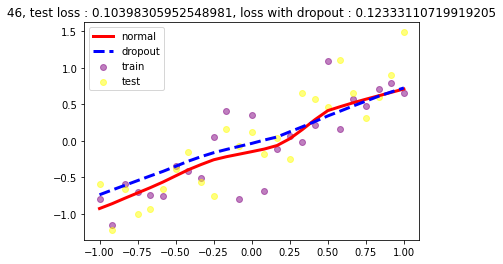

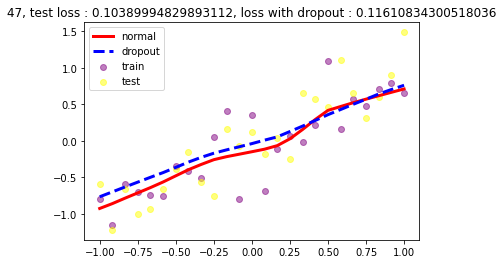

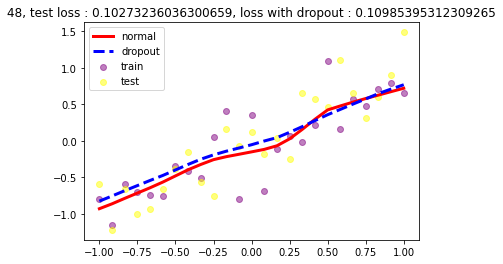

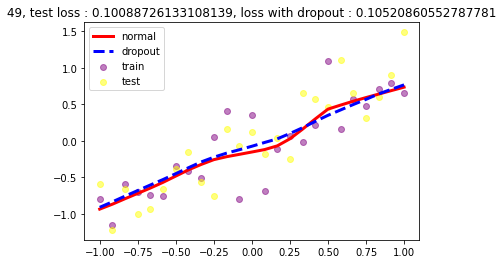

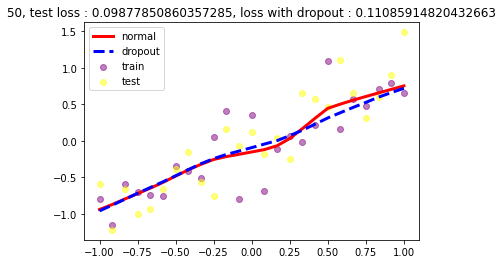

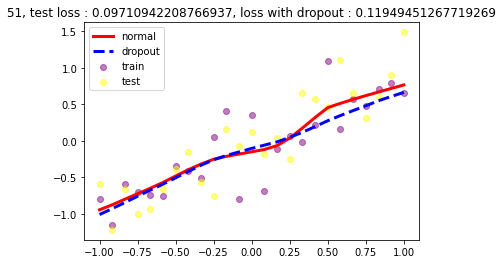

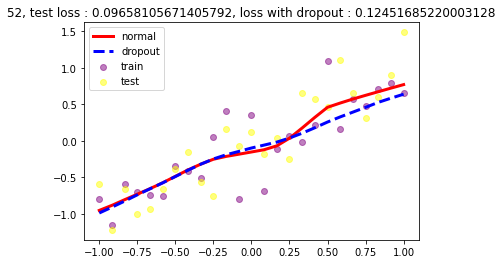

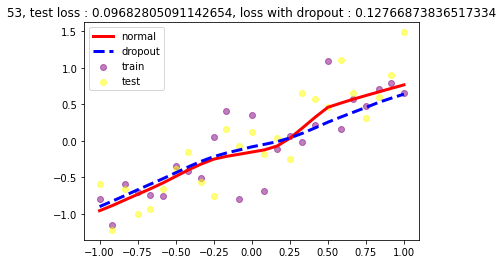

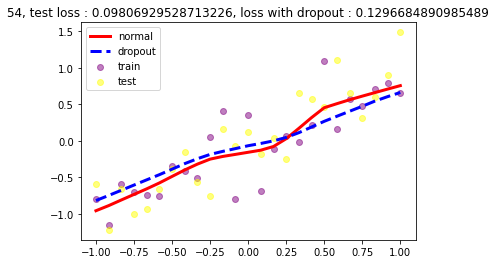

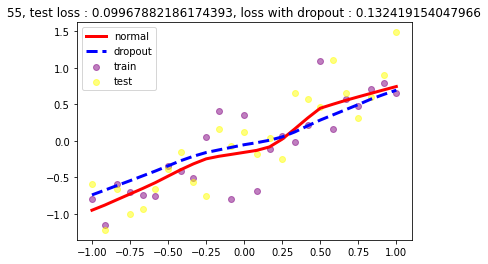

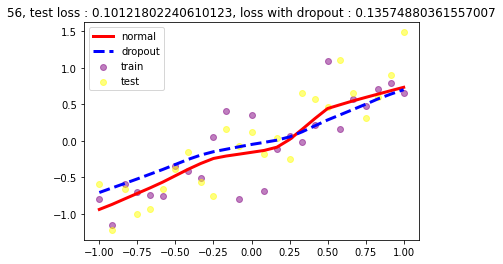

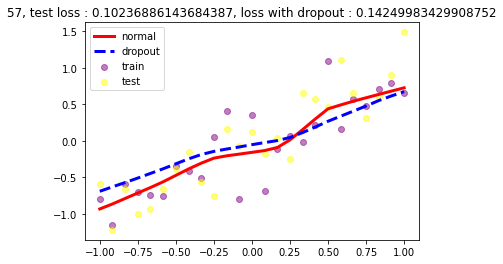

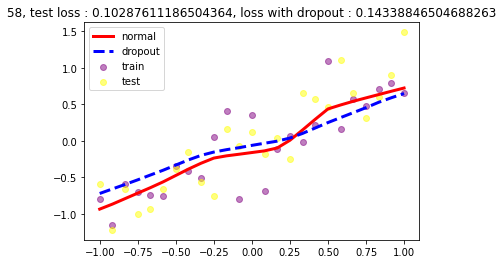

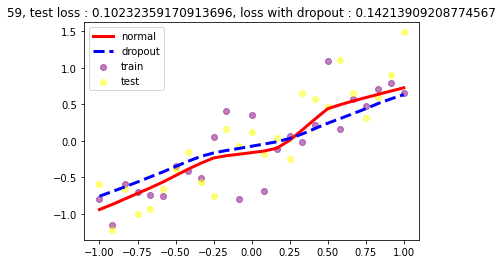

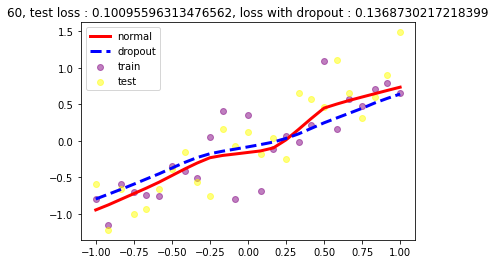

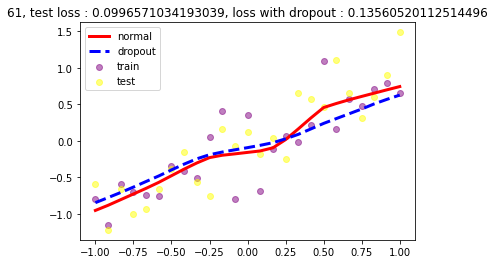

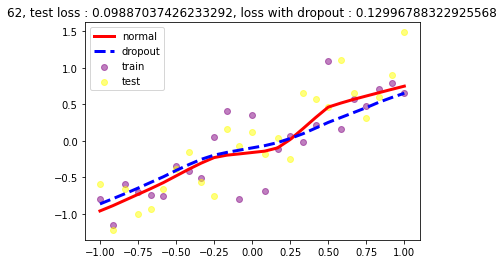

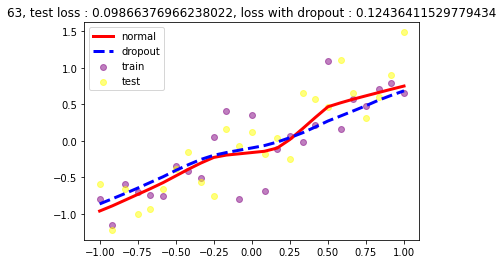

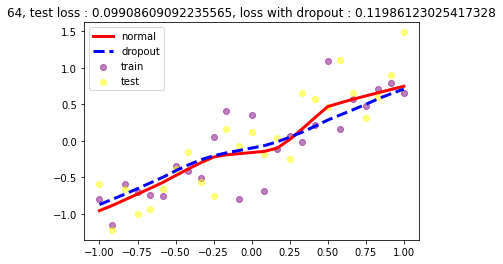

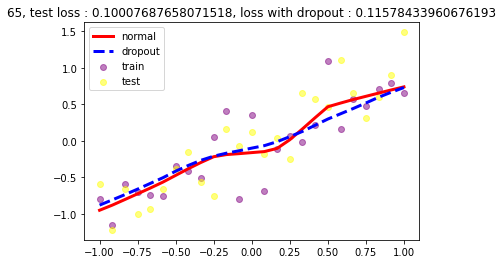

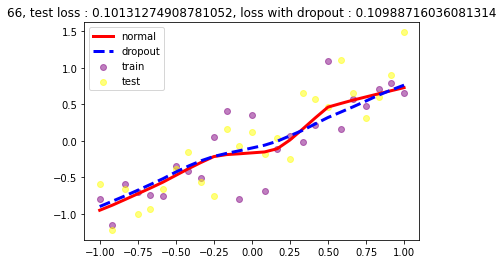

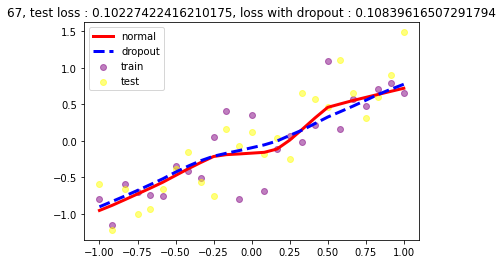

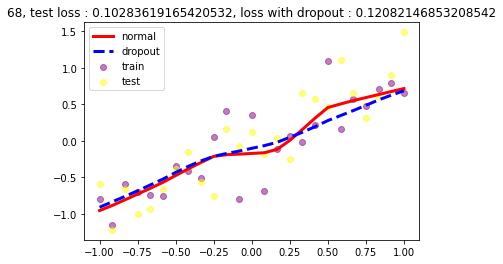

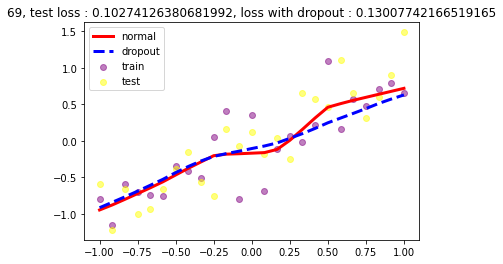

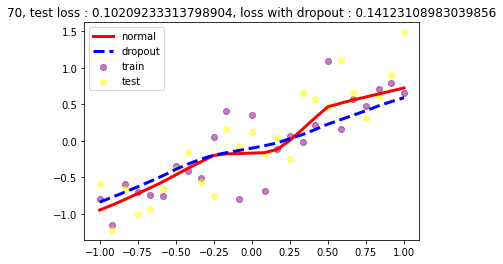

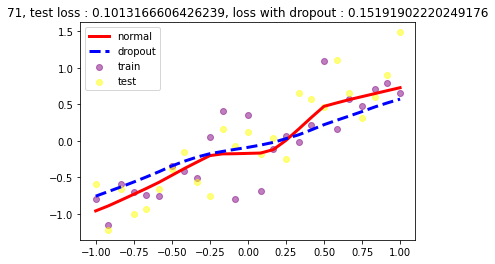

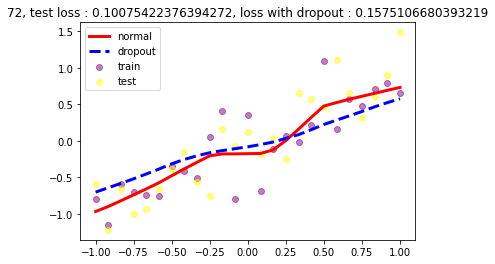

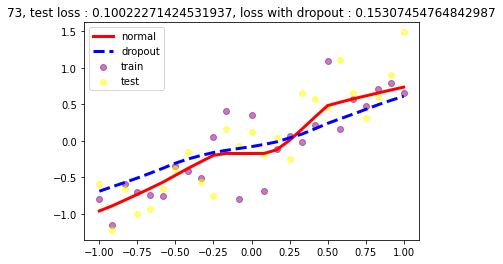

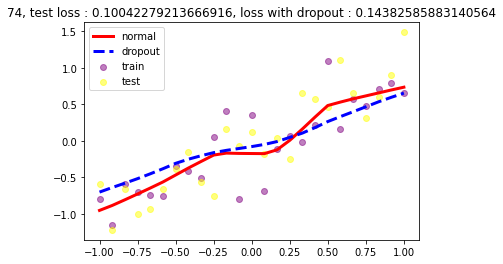

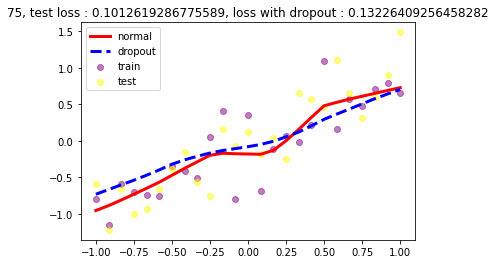

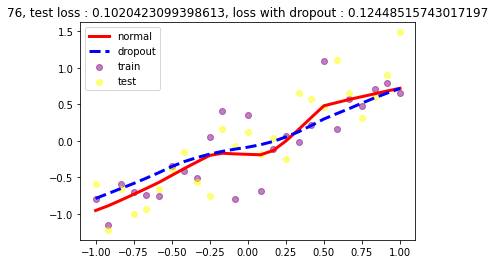

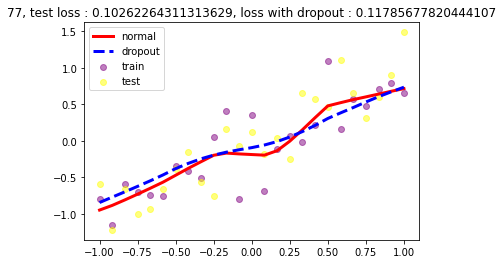

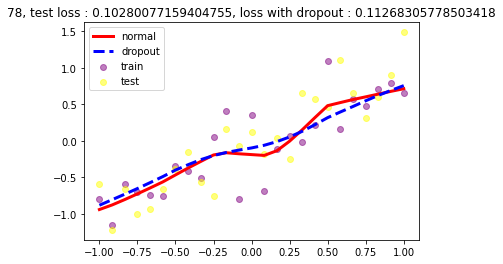

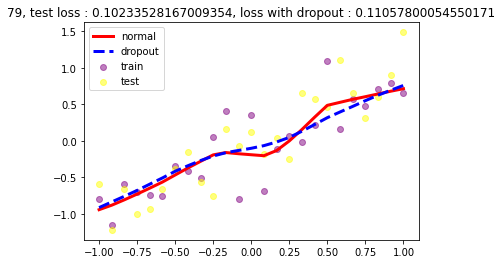

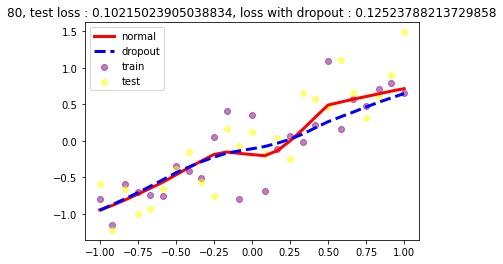

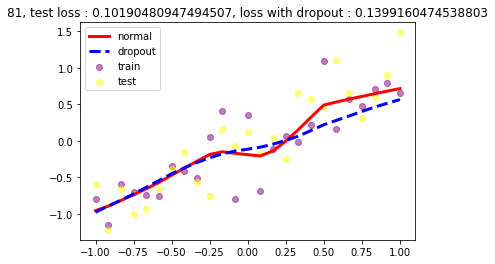

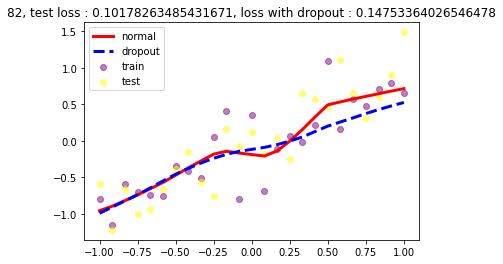

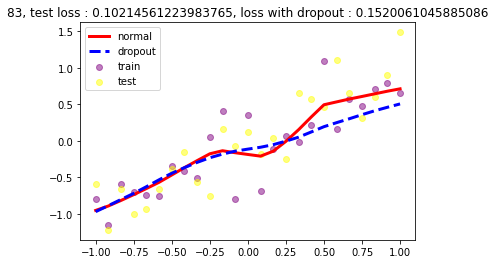

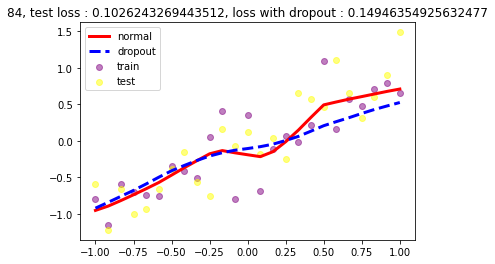

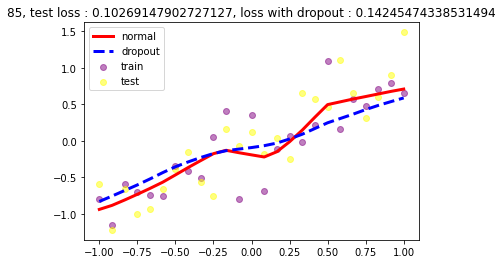

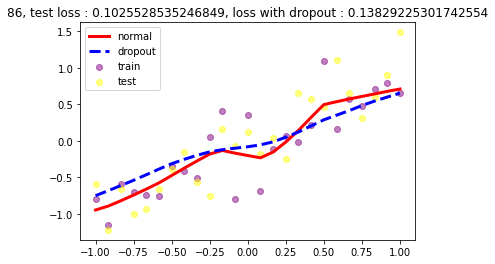

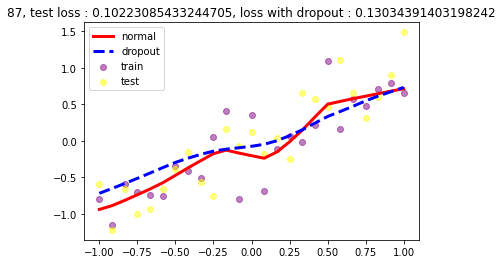

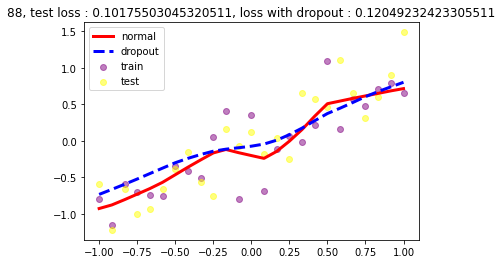

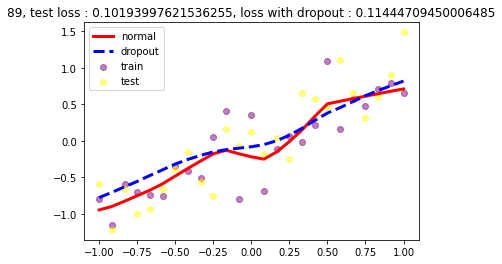

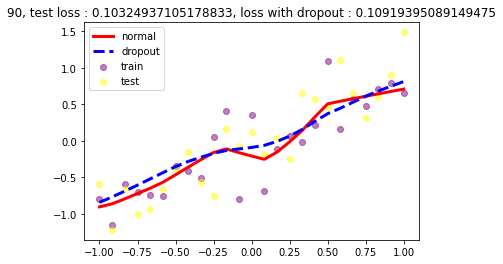

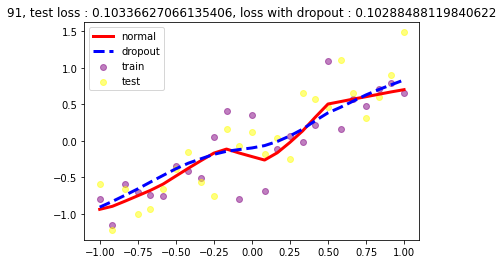

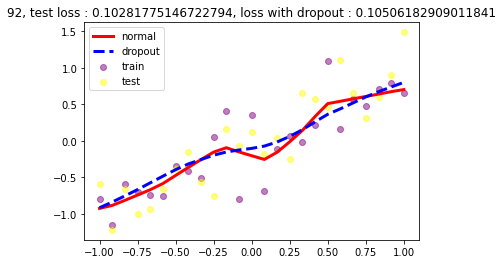

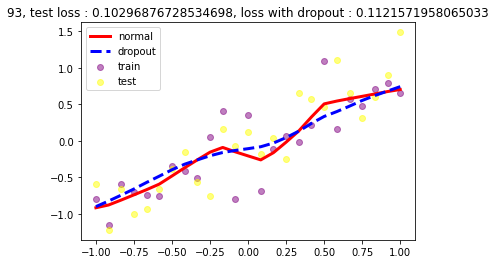

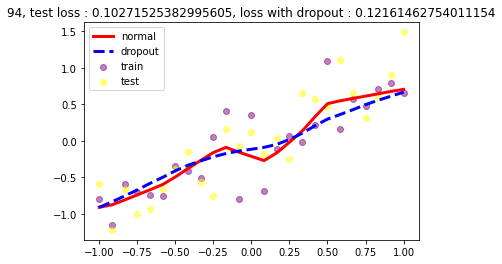

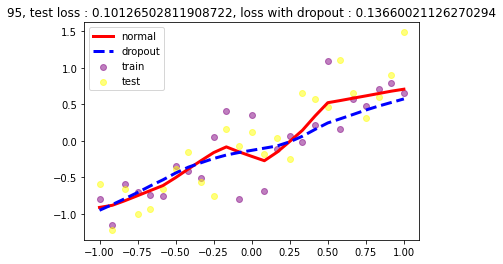

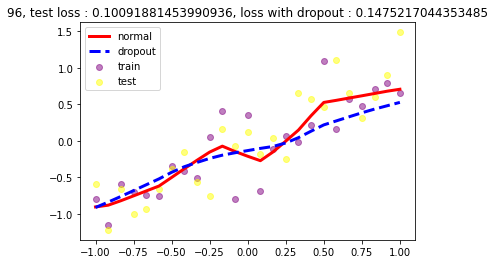

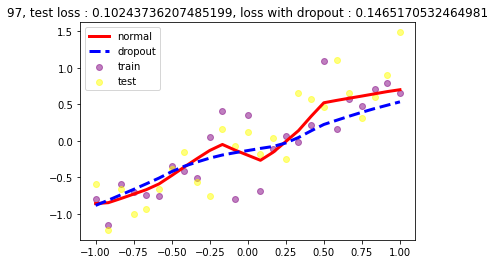

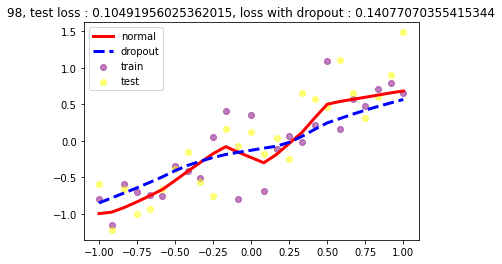

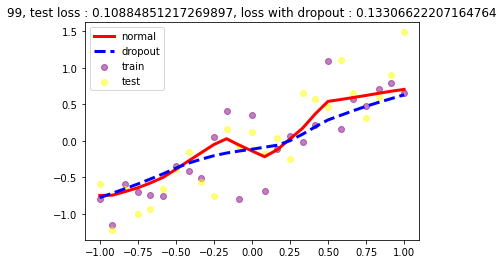

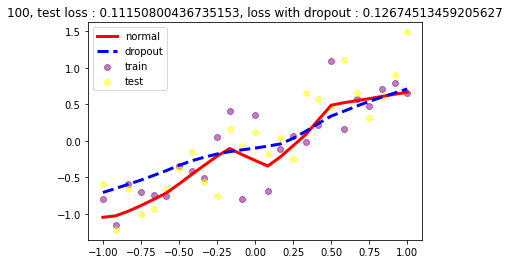

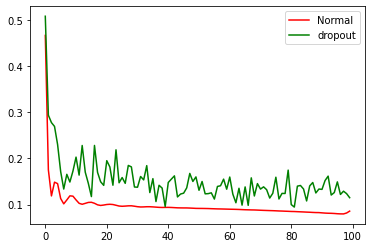

In [38]:
max_epochs = 100
losses = []
losses_dropout=[]
i=0
inputs = X_train
labels = Y_train

for epoch in range(1,max_epochs+1):

  #training normal model
  opt.zero_grad()    
  outputs = model(inputs)
  loss = loss_fn(outputs, labels)
  loss.backward()
  opt.step()

  #training batch normalised moe
  opt_dropout.zero_grad()    
  outputs = model_dropout(inputs)
  loss_dropout = loss_fn(outputs, labels)
  loss_dropout.backward()
  opt_dropout.step()

  losses.append(loss.item())
  losses_dropout.append(loss_dropout.item())

  if i%50 == 0:
    inputs = inputs.view(inputs.shape[0],-1)

    model.eval()
    model_dropout.eval()

    test_pred = model(X_test)
    test_pred_dropout = model_dropout(X_test)

    test_loss = loss_fn(test_pred, Y_test)
    test_loss_dropout = loss_fn(test_pred_dropout, Y_test)

    plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='train')
    plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
    plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'r-', lw=3, label='normal')
    plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'b--', lw=3, label='dropout')

    plt.legend()
    plt.title(f'{epoch}, test loss : {test_loss.item()}, loss with dropout : {test_loss_dropout.item()}')
    plt.show()
    plt.pause(0.5)

    model.train()
    model_dropout.train()

plt.plot(losses,'r', label='Normal')
plt.plot(losses_dropout, 'g', label='dropout')
plt.legend()
plt.show()

# Hyperparameter Tuning

## Outline
1. Integrate Google Collab with local runtime
2. Installing MLFlow and basic usecase
3. Logging parameters with MLFlow
4. Loging image artifacts with MLFlow
5. Logging PyTorch models with MLFlow and loading them

__Hyperparameters__
1. Network Design : 
    * num layers
    * num neurons
    * activation functions
    * type of layers
    * filter sizes, etc.
2. Optimisation Algorithm :
    * type of algorithm
    * learning rate
    * momentum
    * batch size
    * epochs
    * nesterov acceleration, etc.

## Connect to local runtime

recommended to use conda to install jupyter notebook

open mlflow and jupyter in the same folder

https://mlflow.org/

https://research.google.com/colaboratory/local-runtimes.html

http://localhost:5000/

Run these commands on different conda shells and open resulting links in browser

    jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

    mlflow ui

In [4]:
class Params:
  def __init__(self, batch_size, epochs, seed, log_interval):
    self.batch_size = batch_size
    self.epochs = epochs
    self.seed = seed
    self.log_interval = log_interval

args = Params(253,4,0,20)

## Data Loading

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                                 ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
class Model(nn.Module):
  def __init__(self, N_h= 32):
    super().__init__()
    self.N_h = N_h
    self.classifier = nn.Sequential(nn.Linear(784, N_h),
                                    nn.ReLU(),
                                    nn.Linear(N_h, 10)
                                    )
  def forward(self,x):
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [7]:
len(trainloader.dataset) #no. of samples

60000

In [8]:
len(trainloader) #no. of batches

238

In [9]:
model = Model(3)
inputs, labels = next(iter(trainloader))
outputs = model(inputs)
print(outputs.shape)
print(outputs.data.shape)

#the following three are the same stuff
print(outputs.data.max(1)[1])
print(outputs.data.argmax(dim=1))
print(torch.argmax(outputs.data, dim=1))

torch.Size([253, 10])
torch.Size([253, 10])
tensor([2, 7, 7, 2, 2, 7, 7, 7, 7, 2, 7, 2, 7, 7, 2, 7, 7, 5, 7, 7, 7, 7, 2, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7,
        7, 2, 7, 7, 2, 7, 7, 7, 2, 2, 2, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 2, 7,
        7, 7, 2, 2, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 2, 7, 2, 7, 7, 7, 7, 7, 7, 2,
        7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 2, 2, 7, 2, 7, 7, 2, 7, 7, 2, 2, 7, 2, 7, 7, 7, 7, 2, 2, 2, 7, 7,
        2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 2, 7,
        7, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 2, 7, 7, 2, 7, 2, 2, 7, 7, 2,
        7, 7, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 2, 2, 7, 7, 7, 7, 2, 7,
        7, 7, 7, 7, 7, 2, 2, 7, 2, 7, 7, 2, 7, 7, 7, 7, 2, 7, 7, 7, 2, 7, 7, 7,
        2, 7, 7, 7, 7, 2, 2, 2, 7, 7, 7, 7, 7])
tensor([2, 7, 7, 2, 2, 7, 7, 7, 7, 2, 7, 2, 7, 7, 2, 7, 7, 5, 7, 7, 7, 7, 2, 7,
        7, 7, 7, 7, 7, 7, 7,

In [10]:
def train(epoch):
  model.train()

  batch_id=0
  l = len(trainloader)
  for inputs, labels in trainloader:
    batch_id+=1

    opt.zero_grad()    
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    if batch_id%args.log_interval == 0:
      pos = epoch*l + batch_id
      mlflow.log_metric('train loss', 1000*loss.item()/len(inputs))
      print(f'Epoch {epoch} [{batch_id*len(inputs)}/{len(trainloader.dataset)}, {100*batch_id/l} loss : {loss.item()}')

def test(epoch):
  model.eval()
  test_loss=0
  correct=0
  confusion_matrix = np.zeros([10,10])

  batch_id=0
  l = len(testloader)

  with torch.no_grad():
    for inputs, labels in testloader:

      outputs = model(inputs)
      test_loss += loss_fn(outputs, labels).data.item()
      pred = outputs.data.max(1)[1]
      correct += pred.eq(labels.data).sum().item()

      for x, y in zip(pred.numpy(), labels.numpy()):
        confusion_matrix[x][y] += 1
    
    test_loss /= len(testloader.dataset)
    test_accuracy = 100*correct/len(testloader.dataset)

    pos = (epoch+1)*len(trainloader) 
    mlflow.log_metric('test loss', 1000*test_loss)
    mlflow.log_metric('test_accuracy', test_accuracy)
    print(f'Average Loss : {test_loss: 0.4f} Accuracy : {correct}/{len(testloader.dataset)} {test_accuracy:.0f}')

    if epoch==args.epochs:
      classes = np.arange(10)
      fig, ax = plt.subplots()
      im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
      ax.figure.colorbar(im, ax=ax)
      ax.set(xticks=np.arange(confusion_matrix.shape[1]),
             yticks=np.arange(confusion_matrix.shape[0]),
             ylabel='True label',
             xlabel='Predicted label',
             title=f'Epoch {epoch}'
             )
      thresh = confusion_matrix.max()/2
      for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
          ax.text(j,i, int(confusion_matrix[i,j]),
                  ha='center', va='center',
                  color='white' if confusion_matrix[i,j]>thresh else 'black')
      fig.tight_layout()

      imagepath = f'images/{expt_id}.png'
      plt.savefig(imagepath)
      mlflow.log_artifact(imagepath)

  

## Hyperparameter Training

In [11]:
args.epochs = 8


LR = 0.01, Momentum = 0.90, Hidden nodes = 16

Epoch 1 [5060/60000, 8.403361344537815 loss : 1.2239364385604858
Epoch 1 [10120/60000, 16.80672268907563 loss : 0.5253352522850037
Epoch 1 [15180/60000, 25.210084033613445 loss : 0.4686279594898224
Epoch 1 [20240/60000, 33.61344537815126 loss : 0.4038797616958618
Epoch 1 [25300/60000, 42.016806722689076 loss : 0.3877224326133728
Epoch 1 [30360/60000, 50.42016806722689 loss : 0.3916113078594208
Epoch 1 [35420/60000, 58.8235294117647 loss : 0.27383163571357727
Epoch 1 [40480/60000, 67.22689075630252 loss : 0.27273398637771606
Epoch 1 [45540/60000, 75.63025210084034 loss : 0.3071258068084717
Epoch 1 [50600/60000, 84.03361344537815 loss : 0.3369005620479584
Epoch 1 [55660/60000, 92.43697478991596 loss : 0.3555416166782379
Average Loss :  0.0012 Accuracy : 9161/10000 92
Epoch 2 [5060/60000, 8.403361344537815 loss : 0.3006136119365692
Epoch 2 [10120/60000, 16.80672268907563 loss : 0.3467462956905365
Epoch 2 [15180/60000, 25.210084033613445 loss

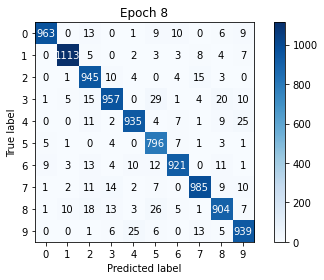

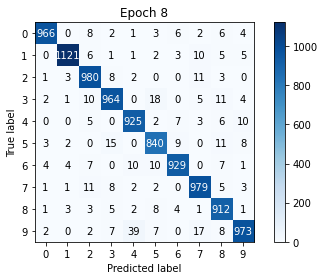

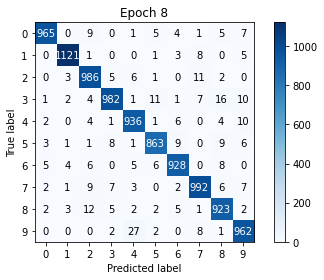

In [14]:
mlflow.set_experiment('Check hidden nodes')
for lr in [0.01]:#,0.05,0.1]:
  for momentum in [0.9]:#,0.92,0.95]:
    for hidden_nodes in [16,32,48]:

      expt_id = f'{int(lr*100)}_{int(momentum*100)}_{hidden_nodes}'
      print(f'\nLR = {lr:0.2f}, Momentum = {momentum:0.2f}, Hidden nodes = {hidden_nodes}\n')

      model = Model(hidden_nodes)
      loss_fn = nn.CrossEntropyLoss()
      opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      with mlflow.start_run() as run:
        for key,value in vars(args).items():
          mlflow.log_param(key,value)
        mlflow.log_param('lr',lr)
        mlflow.log_param('momentum', momentum)
        mlflow.log_param('hidden_nodes', hidden_nodes)

        for epoch in range(1,args.epochs+1):
          train(epoch)
          test(epoch)
          mlflow.pytorch.log_model(model, 'models')


LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Epoch 1 [5060/60000, 8.403361344537815 loss : 1.134663462638855
Epoch 1 [10120/60000, 16.80672268907563 loss : 0.4972832500934601
Epoch 1 [15180/60000, 25.210084033613445 loss : 0.4493573009967804
Epoch 1 [20240/60000, 33.61344537815126 loss : 0.30977416038513184
Epoch 1 [25300/60000, 42.016806722689076 loss : 0.3712623119354248
Epoch 1 [30360/60000, 50.42016806722689 loss : 0.2882250249385834
Epoch 1 [35420/60000, 58.8235294117647 loss : 0.38313645124435425
Epoch 1 [40480/60000, 67.22689075630252 loss : 0.32572001218795776
Epoch 1 [45540/60000, 75.63025210084034 loss : 0.2939295172691345
Epoch 1 [50600/60000, 84.03361344537815 loss : 0.2624714970588684
Epoch 1 [55660/60000, 92.43697478991596 loss : 0.3550189733505249
Average Loss :  0.0011 Accuracy : 9231/10000 92
Epoch 2 [5060/60000, 8.403361344537815 loss : 0.19577820599079132
Epoch 2 [10120/60000, 16.80672268907563 loss : 0.18005749583244324
Epoch 2 [15180/60000, 25.210084033613445 lo

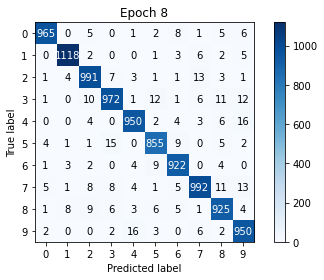

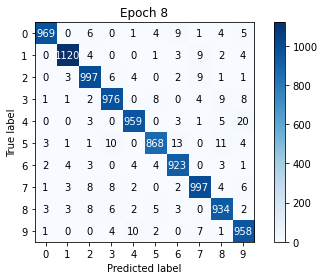

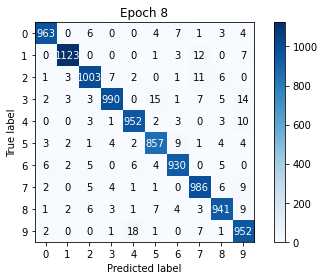

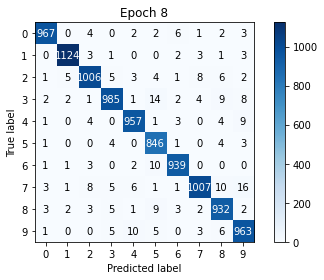

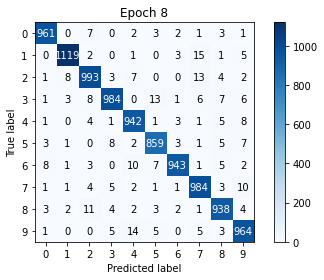

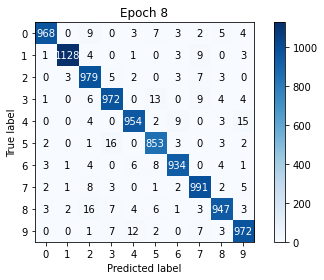

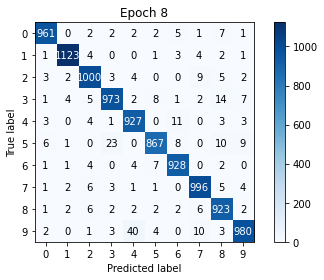

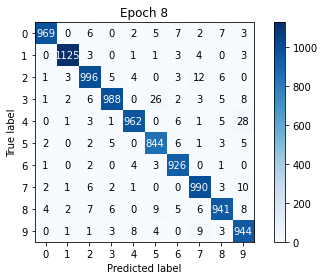

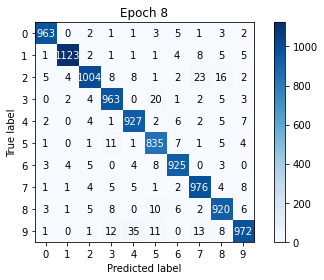

In [15]:
mlflow.set_experiment('Fixed nH')
for lr in [0.01,0.05,0.1]:
  for momentum in [0.9,0.92,0.95]:
    for hidden_nodes in [48]:

      expt_id = f'{int(lr*100)}_{int(momentum*100)}_{hidden_nodes}'
      print(f'\nLR = {lr:0.2f}, Momentum = {momentum:0.2f}, Hidden nodes = {hidden_nodes}\n')

      model = Model(hidden_nodes)
      loss_fn = nn.CrossEntropyLoss()
      opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      with mlflow.start_run() as run:
        for key,value in vars(args).items():
          mlflow.log_param(key,value)
        mlflow.log_param('lr',lr)
        mlflow.log_param('momentum', momentum)
        mlflow.log_param('hidden_nodes', hidden_nodes)

        for epoch in range(1,args.epochs+1):
          train(epoch)
          test(epoch)
          mlflow.pytorch.log_model(model, 'models')

In [22]:
model_load = mlflow.pytorch.load_model('mlruns/2/6d07c0ba4cba4bb0848b157dd103ba0f/artifacts/models') #path copied from mlflow ui
#model_load = mlflow.pytorch.load_model('file:///D:/ProgramData/python%20workspace/mlruns/1/6d07c0ba4cba4bb0848b157dd103ba0f/artifacts/models') #path copied from mlflow ui

In [23]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()

[]

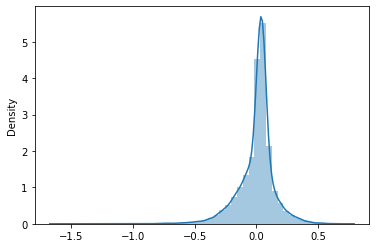

In [24]:
sns.distplot(weight_layer0.ravel())
plt.plot()

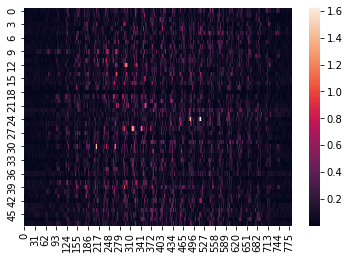

In [26]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [27]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()

In [28]:
weight_layer1.shape

(10, 48)

[]

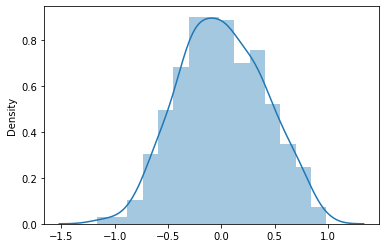

In [29]:
sns.distplot(weight_layer1.ravel())
plt.plot()

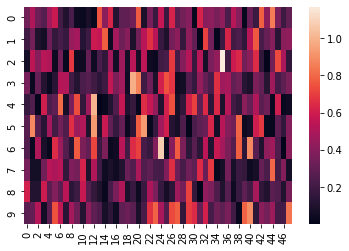

In [30]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

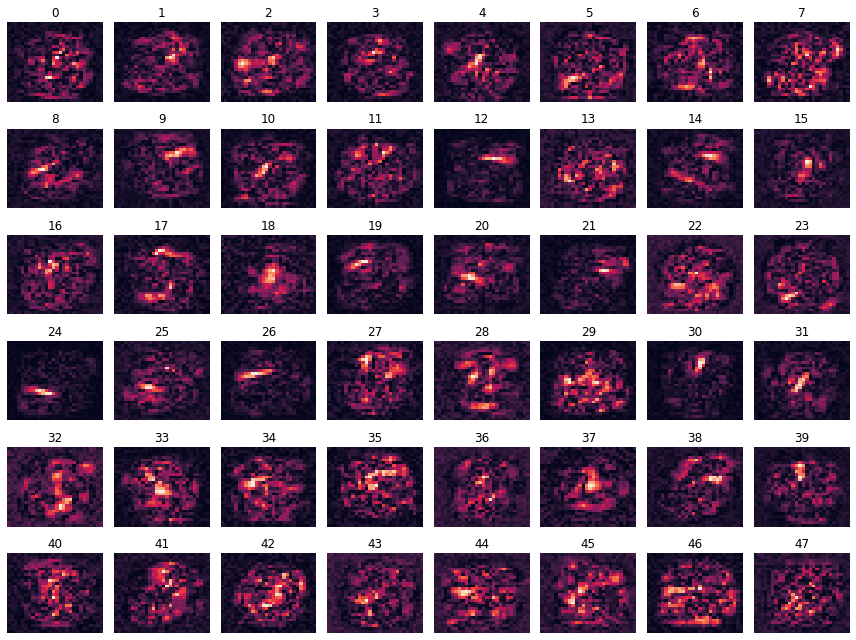

In [31]:
# what each neuron in hidden layer learns
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48):
  ax1 = fig.add_subplot(nrows, ncols, i+1)
  sns.heatmap(np.abs(weight_layer0[i,0:784]).reshape(28,28), ax=ax1, cbar=False)
  ax1.axis('off')
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_title(i)
plt.tight_layout()
plt.show()